### data cleaning and visualizing 

In [105]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
!pip install torch.summary;
from torch.utils.data import DataLoader , Dataset , random_split
from tqdm import tqdm
import sklearn
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

#### train - val split 

In [107]:
if torch.cuda.is_available:
    device='cuda'
else:
    device='cpu'

train : 91.70873352691534% val : 8.291266473084661%


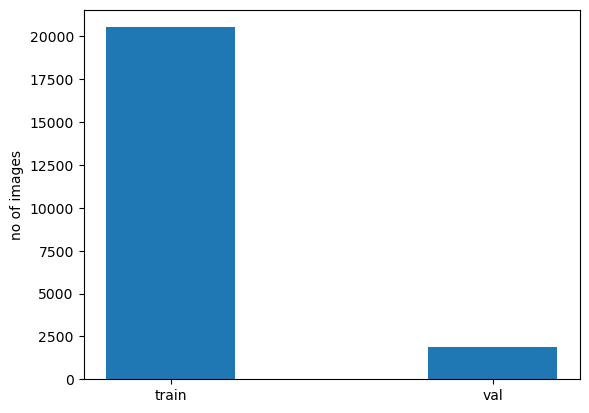

In [108]:
train_data = os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/train')
val_data = os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/validation')
test_data = os.listdir('/kaggle/input/google-research-identify-contrails-reduce-global-warming/test')
fig,ax = plt.subplots(1,1)
ax.bar(x=[2,4],height=[len(train_data),len(val_data)],orientation='vertical');
ax.set_ylabel('no of images');
ax.set_xticks([2,4],['train','val']);
print(f'train : {len(train_data)/(len(val_data)+len(train_data))*100}% val : {100-(len(train_data)/(len(val_data)+len(train_data))*100)}%')

### converting into requried fromat 
* the data contains 8 bands (8-16 bands of GOES-16 Advanced Baseline Imager (ABI)) . the ash colour format suits best in visulazing contrails
* each band has height * widith * time shape 
* where band[:,timestamp] image data corresponds to that timestamp
* masks have shape height * widith * 1 * R this mask corresponds to 4th timestamp images r dentons i'th annotator mask 
* there is another mask which is avarage of every annotator 

In [109]:
# ash colour format 
_T11_BOUNDS = (243, 303)
_CLOUD_TOP_TDIFF_BOUNDS = (-4, 5)
_TDIFF_BOUNDS = (-4, 2)

def normalize_range(data, bounds):
    """Maps data to the range [0, 1]."""
    return (data - bounds[0]) / (bounds[1] - bounds[0])

def falseColour(band11,band14,band15):
    r = normalize_range(band15 - band14, _TDIFF_BOUNDS)
    g = normalize_range(band14 - band11, _CLOUD_TOP_TDIFF_BOUNDS)
    b = normalize_range(band14, _T11_BOUNDS)
    false_color = np.clip(np.stack([r, g, b], axis=2), 0, 1)
    return false_color
# i will be using a premade ash colour data set to  avoid this step 

### visulaizing contrails and dataset stats
* check 1 : how many images contatins contrails
* check 2 : are there any duplicates 
* check 3 : is train and validation data consistent

In [110]:
# Define the path to the images
ash_path = '/kaggle/input/contrails-images-ash-color/contrails'
ash_data = os.listdir(ash_path)

current_idx = 0  # Initialize the current index

def display_image(idx):
    clear_output(wait=True)  # Clear the previous output
    fig, ax = plt.subplots(1, 2)
    plt.subplots_adjust(bottom=0.25)
    img1 = np.load(os.path.join(ash_path, ash_data[idx]))
    img1 = img1.astype('float64')
    inp = ax[0].imshow(img1[:, :, :-1])
    mask = ax[1].imshow(img1[:, :, -1])
    print(np.max(img1[:, :, :-1]) , np.max(img1[:, :,-1]))
    ax[0].set_title("Input Image")
    ax[1].set_title("Mask")
    plt.show()
slider = widgets.IntSlider(value=current_idx, min=0, max=len(ash_data)-1, step=1, description='Index:')
widgets.interact(display_image, idx=slider);

interactive(children=(IntSlider(value=0, description='Index:', max=22384), Output()), _dom_classes=('widget-in…

In [111]:
class CustomDataset(Dataset):
    def __init__(self,path):
        self.path = path
    def __len__(self):
        self.data = os.listdir(self.path)
        return len(self.data)
    def __getitem__(self,idx):
        path_to_file = self.data[idx]
        img = np.load(f'{self.path}/{path_to_file}')
        inp = img[:,:,:-1]
        mask = img[:,:,-1]
        inp = torch.tensor(inp).to(device)
        mask=torch.tensor(mask).to(device)
        inp=inp.permute(2,0,1)
        return inp,mask  

In [112]:
dataset = CustomDataset(ash_path)
train_size = int(0.95*len(dataset))
val_size=len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset,[train_size, val_size])
train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True)
val_loader=DataLoader(val_dataset,batch_size=16,shuffle=False)

torch.Size([16, 3, 256, 256]) torch.Size([16, 256, 256])


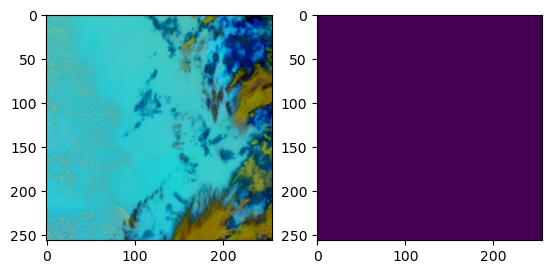

In [113]:
inp , mask = next(iter(train_loader))
print(inp.shape,mask.shape)
tmp =inp[0]
tmp2=mask[0]
tmp=tmp.cpu().permute(1,2,0)
tmp=tmp.numpy().astype('float64')
tmp2=tmp2.cpu().numpy().astype('float64')
fig ,ax = plt.subplots(1,2)
ax[0].imshow(tmp)
ax[1].imshow(tmp2)

# model
lets train a unet

In [114]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x


class InConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(Up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

class Unet(nn.Module):
    def __init__(self, in_channels, classes):
        super(Unet, self).__init__()
        self.n_channels = in_channels
        self.n_classes =  classes

        self.inc = InConv(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [121]:
model=Unet(3,1)
model.to(device);
summary(model,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
            InConv-8         [-1, 64, 256, 256]               0
         MaxPool2d-9         [-1, 64, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]          73,856
      BatchNorm2d-11        [-1, 128, 128, 128]             256
             ReLU-12        [-1, 128, 128, 128]               0
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14        [-1, 128, 1

In [122]:
def Dice_loss(pred, mask):
    smooth = 1e-6     
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    dice_loss = 1.0 - dice_coefficient
    return dice_loss
def DiceScore(pred,mask):
    smooth = 1e-6     
    intersection = torch.sum(pred * mask)
    union = torch.sum(pred) + torch.sum(mask)
    dice_coefficient = (2.0 * intersection + smooth) / (union + smooth)
    return dice_coefficient

In [129]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
criterion = Dice_loss

In [132]:
train_losses = []
val_losses=[]
epochs = 20

In [134]:
for epoch in range(epochs):
    model.train()
    running_loss=0.0
    cnt=0
    for  batch_idx, (inputs, masks) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(inputs.float())
        loss = criterion(output,masks)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        cnt+=1
    train_losses.append(running_loss/cnt)
    print(f'train epoch {epoch} train_loss : {running_loss/cnt}')
    running_loss=0.0
    cnt=0
    model.eval()
    for  batch_idx, (inputs, masks) in enumerate(val_loader):
        outputs = model(inputs)
        loss=criterion(outputs,masks)
        running_loss+=loss.item()
        cnt+=1
    val_losses.append(running_loss/cnt)
    print(f'epoch : {epoch} val_loss : {running_loss/cnt}')

train epoch 0 train_loss : 0.8038680509517068


RuntimeError: Input type (c10::Half) and bias type (float) should be the same